In [2]:
library(tidyverse)
library(survival)
library(survminer)
library(here)
options(here.quiet = TRUE)

In [3]:
df <-read.delim("../data/baseline_263_visit_clinical.txt")
# Format the categorical variable to appropriate factor levels.
df <- df %>%
  mutate(
    Sex = d_pt_sex,
    Age = d_dx_amm_age,
    BMI = d_dx_amm_bmi,
    Transplant = d_amm_tx_asct_1st,
    PFS = censpfs,
    PFS.time = ttcpfs,
    OS = censos,
    OS.time = ttcos,
    Treatment = case_when(
      d_tx_induction_cat == "chemo_imid_pi_steroid" ~ "imid_pi_steroid",
      d_tx_induction_cat == "chemo_pi_steroid" ~ "pi_steroid",
      TRUE ~ d_tx_induction_cat
    ),
    risk = case_when(
      davies_based_risk %in% c("no_risk_data", "not_calculable") ~ NA_character_,
      TRUE ~ as.character(davies_based_risk)
    ),
    ECOG = case_when(
      d_dx_amm_ecog %in% c("3", "4") ~ ">=3",
      TRUE ~ as.character(d_dx_amm_ecog)
    ),
    Race = case_when(
      d_pt_race_1 %in% c("asian_nos", "unknown") ~ "others/unknown",
      d_pt_race_1 %in% c("black_african_american") ~ "black",
      TRUE ~ as.character(d_pt_race_1)
    ),
    ISS_stage = case_when(
      d_dx_amm_iss_stage %in% c("1") ~ "stage I",
      d_dx_amm_iss_stage %in% c("2") ~ "stage II",
      d_dx_amm_iss_stage %in% c("3") ~ "stage III",
      TRUE ~ as.character(d_dx_amm_iss_stage)
    )
  ) %>%
  mutate(
    Treatment = factor(Treatment, levels = c("pi_steroid", "imid_pi_steroid", "imid_steroid")),
    risk = factor(risk, levels = c("standard_risk", "high_risk")),
    ECOG = factor(ECOG, levels = c("0", "1", "2", ">=3")),
    Race = factor(Race, levels = c("white", "black", "others/unknown")),
    ISS_stage = factor(ISS_stage, levels = c("stage I", "stage II", "stage III"))
  )

# Display the first few rows of the transformed data frame
df %>%
  select(Sex, BMI, Transplant, Treatment, risk, ECOG, Race, ISS_stage)%>% head()

,Sex,BMI,Transplant,Treatment,risk,ECOG,Race,ISS_stage
,<chr>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
1,male,31.20,no,pi_steroid,high_risk,0,white,stage III
2,male,24.26,no,imid_pi_steroid,NA,1,white,stage I
3,male,25.21,yes,imid_pi_steroid,high_risk,1,white,stage II
4,female,33.12,no,pi_steroid,NA,2,white,NA
5,male,42.78,no,imid_pi_steroid,high_risk,1,white,stage II
6,male,25.73,yes,imid_pi_steroid,standard_risk,0,white,stage II



  stage I  stage II stage III 
       91        95        66 

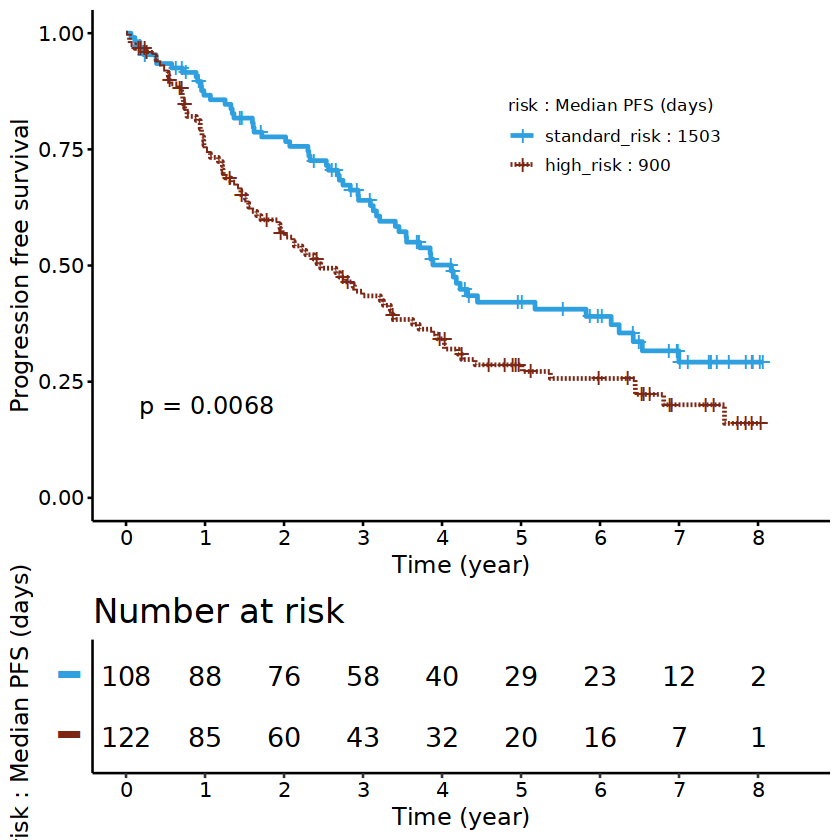

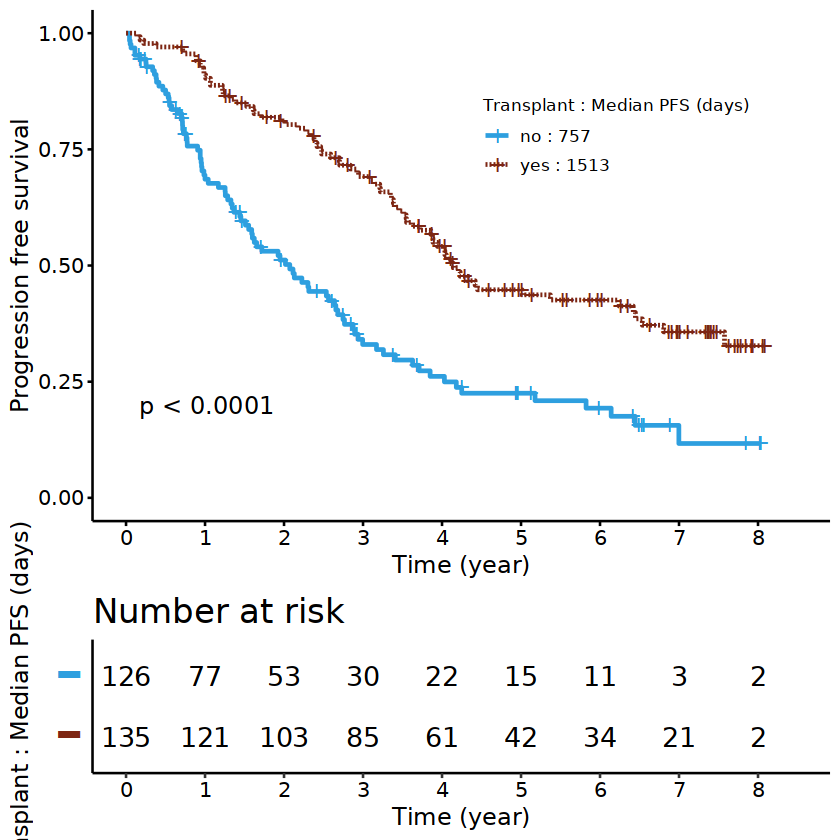

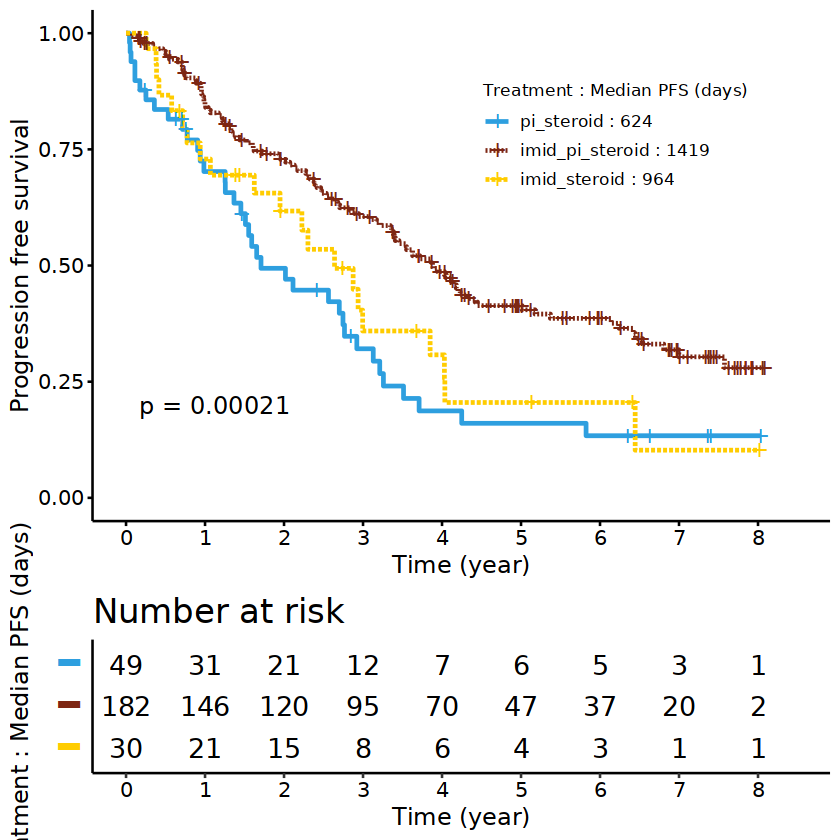

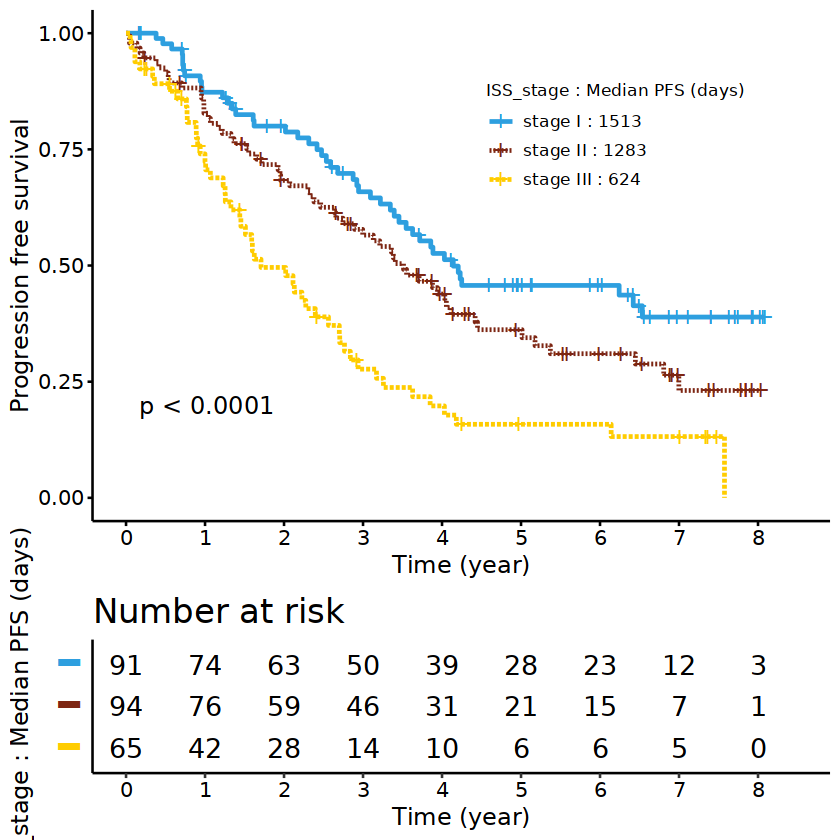

In [5]:
# Figure 1F
options(repr.plot.width=7, repr.plot.height=7)

## PFS
Var_list <-c("risk","Transplant","Treatment","ISS_stage")
data <-as.data.frame(df)
table(data$group)
# Loop through the Vars and create survival plots
for (Var in Var_list) {
  
  # Check if the column exists in the data
  if (!Var %in% colnames(data)) {
    next
  }
  
  data$group <- data[[Var]]
  
  df2 <-data%>%drop_na(group)
  if (length(unique(df2$group)) < 2) {
    next
  }
  # Cox proportional hazards model with PFS as the survival outcome variable
  # and group as the predictor variable
  coxph_fit <- coxph(Surv(PFS.time, PFS) ~ group, data = df2)
  
  # Fit survival curves for PFS by group
  sfit <- survfit(Surv(PFS.time, PFS) ~ group, data = df2)
  
  median <-surv_median(sfit)
  
  df$group <- as.factor(df[[Var]])
  
  # Get the number of samples in each group
  median_group1 <- median$median[1]
  median_group2 <- median$median[2]
  median_group3 <- if (length(levels(df$group)) >= 3) {
    median$median[3]
  } else {
    0
  }
  median_group4 <- if (length(levels(df$group)) == 4) {
    median$median[4]
  } else {
    0
  }
    
  colors <- if (length(levels(df$group)) == 3) {
    c("#2E9FDF", "#7d2613", "#FFCC00")
  } else if (length(levels(df$group)) == 4) {
    c("#2E9FDF","#FFCC00", "#FFCC99","#7d2613")
  } else {
    c("#2E9FDF", "#7d2613")
  }
  
  legend_labels <- if (length(levels(df$group)) == 3) {
    c(paste0(levels(df$group)[1], " : ", median_group1),
      paste0(levels(df$group)[2], " : ", median_group2),
      paste0(levels(df$group)[3], " : ", median_group3))
  } else if (length(levels(df$group)) == 4) {
    c(paste0(levels(df$group)[1], " : ", median_group1),
      paste0(levels(df$group)[2], " : ", median_group2),
      paste0(levels(df$group)[3], " : ", median_group3),
      paste0(levels(df$group)[4], " : ", median_group4))
  } else {
    c(paste0(levels(df$group)[1], " : ", median_group1),
      paste0(levels(df$group)[2], " : ", median_group2))
  }
  
  
  # Create survival plot
  p <- ggsurvplot(
    sfit,                     # survfit object with calculated statistics.
    data = df2,              # data used to fit survival curves. 
    risk.table = TRUE,        # show risk table.
    pval = TRUE,              # show p-value of log-rank test.
    #conf.int = TRUE,          # show confidence intervals for point estimates of survival curves.
    xlim = c(0, 3100),        # present narrower X axis, but not affect survival estimates.
    break.time.by = 365.25,      # break X axis in time intervals by 365.
    xscale = 365.25,
    risk.table.y.text.col = T,# colour risk table text annotations.
    risk.table.y.text = FALSE,# show bars instead of names instead of text annotations in legend of risk table.
    risk.table.pPFS="in",
    ylab = "Progression free survival",
    xlab = "Time (year)",
    size = 1,
    linetype = "strata",      # change line type by groups
    legend = c(0.7,0.75),
    legend.title =paste0(Var," : Median PFS (days)"),
    risk.table.title=NULL,
    risk.table.height=0.3,
    tables.theme = theme_survminer(font.main = 20),
    risk.table.fontsize=5.5,
    y.text = FALSE,
    palette = colors, # custom color palette
    legend.labs = legend_labels,
    font.title = c(10, "bold", "black")
  )+ 
    guides(colour = guide_legend(nrow = length(levels(df$group))))

  print(p)
}